## Training with multiple SNR and Modulation (QPSK, 8PSK, 16-QAM)

In [6]:
"""
Deep Deterministic Policy Gradient (DDPG), Reinforcement Learning.
P2P network, net bit rate, energy harvesting example for training.
Thanks to : https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/contents/9_Deep_Deterministic_Policy_Gradient_DDPG
Using:
tensorflow 1.0
"""
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import DDPG_CLASS
#from .DDPG_CLASS import * 

np.random.seed(1)
tf.set_random_seed(1)



#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10

for modulation in range(0,3):
    for snr in range(-10,22,2):
    #for modulation in range(1):
        var = 10

        tf.reset_default_graph()
        sess = tf.Session()
        with tf.name_scope('S'):
            S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
        with tf.name_scope('R'):
            R = tf.placeholder(tf.float32, [None, 1], name='r')
        with tf.name_scope('S_'):
            S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
        DDPG_CLASS.S=S
        DDPG_CLASS.R=R
        DDPG_CLASS.S_=S_
        actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
        critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
        actor.add_grad_to_graph(critic.a_grads)
        M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)


        sess.run(tf.global_variables_initializer())
        saver=tf.train.Saver(max_to_keep=100)

        if OUTPUT_GRAPH:
            tf.summary.FileWriter("logs/", sess.graph)

        print("modulation=",modulation,"snr=",snr)

        for i in range(MAX_EPISODES):
    
            s = env.reset_P2P(snr)

            ep_reward = 0
            for j in range(MAX_EP_STEPS):
                a = actor.choose_action(s)
                a = np.random.normal(a, var)
                a=np.clip(a,0,1)
                s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

                M.store_transition(s, a, r , s_)

                if M.pointer > MEMORY_CAPACITY:
                    #tip and tip2 are only for printing`#
                    if tip == 1:
                        print("memory full",j,i)
                        tip=0
                    var *= 0.9995  # decay the action randomness
                    if tip2 == 1 and var<0.00000001:
                        print("var zero",j,i)
                        tip2=0
                        
                    b_M = M.sample(BATCH_SIZE)
                    b_s = b_M[:, :state_dim]
                    b_a = b_M[:, state_dim: state_dim + action_dim]
                    b_r = b_M[:, -state_dim - 1: -state_dim]
                    b_s_ = b_M[:, -state_dim:]

                    critic.learn(b_s, b_a, b_r, b_s_)
                    actor.learn(b_s)

                s = s_
                
                ep_reward += r


            if i % 30 == 0 :
                print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
                print("ave_reward",ep_reward/(j+1))
                
                
                
        save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
        print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

modulation= 0 snr= -10
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 0
ave_reward 10410.332564535902
net bit rate= 167221.96207069396 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 30
ave_reward 8970.462778191757
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.649872 ] epoch 60
ave_reward 13239.383831246098
net bit rate= 4.68178221225828e-09 action [0.65903037] solar,channel,battery [-0.031192    1.2813557   0.29379618] epoch 90
ave_reward 5680.862502336041
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.487704 ] epoch 120
ave_reward 9676.769709005825
net bit rate= 77759.15947420071 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 150
ave_reward 13321.328348758852
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 180
ave_reward 9380.833288530454
net bit rate

## Training with multiple SNR

In [4]:
"""
Deep Deterministic Policy Gradient (DDPG), Reinforcement Learning.
P2P network, net bit rate, energy harvesting example for training.
Thanks to : https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/contents/9_Deep_Deterministic_Policy_Gradient_DDPG
Using:
tensorflow 1.0
"""
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import DDPG_CLASS
#from .DDPG_CLASS import * 

np.random.seed(1)
tf.set_random_seed(1)



#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10

for temp in range(1):
    for snr in range(-10,10,2):
    #for modulation in range(1):
        var = 10

        tf.reset_default_graph()
        sess = tf.Session()
        with tf.name_scope('S'):
            S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
        with tf.name_scope('R'):
            R = tf.placeholder(tf.float32, [None, 1], name='r')
        with tf.name_scope('S_'):
            S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
        DDPG_CLASS.S=S
        DDPG_CLASS.R=R
        DDPG_CLASS.S_=S_
        actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
        critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
        actor.add_grad_to_graph(critic.a_grads)
        M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)


        sess.run(tf.global_variables_initializer())
        saver=tf.train.Saver(max_to_keep=100)

        if OUTPUT_GRAPH:
            tf.summary.FileWriter("logs/", sess.graph)

        print("modulation=",modulation,"snr=",snr)

        for i in range(MAX_EPISODES):
    
            s = env.reset_P2P(snr)

            ep_reward = 0
            for j in range(MAX_EP_STEPS):
                a = actor.choose_action(s)
                a = np.random.normal(a, var)
                a=np.clip(a,0,1)
                s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

                M.store_transition(s, a, r , s_)

                if M.pointer > MEMORY_CAPACITY:
                    #tip and tip2 are only for printing`#
                    if tip == 1:
                        print("memory full",j,i)
                        tip=0
                    var *= 0.9995  # decay the action randomness
                    if tip2 == 1 and var<0.00000001:
                        print("var zero",j,i)
                        tip2=0
                        
                    b_M = M.sample(BATCH_SIZE)
                    b_s = b_M[:, :state_dim]
                    b_a = b_M[:, state_dim: state_dim + action_dim]
                    b_r = b_M[:, -state_dim - 1: -state_dim]
                    b_s_ = b_M[:, -state_dim:]

                    critic.learn(b_s, b_a, b_r, b_s_)
                    actor.learn(b_s)

                s = s_
                
                ep_reward += r


            if i % 30 == 0 :
                print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
                print("ave_reward",ep_reward/(j+1))
                
                
                
        save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
        print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

modulation= 0 snr= -10
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 0
ave_reward 10397.947921282417
net bit rate= 167221.96207069396 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 30
ave_reward 8965.948561702873
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.649872 ] epoch 60
ave_reward 13239.384182563139
net bit rate= 10.269756120306216 action [0.945073] solar,channel,battery [-0.031192    1.2813557   0.20963328] epoch 90
ave_reward 5678.144522168757
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.487704 ] epoch 120
ave_reward 9676.768120230994
net bit rate= 77759.15947420071 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 150
ave_reward 13321.328348758852
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 180
ave_reward 9380.833288530454
net bit rate= 0.

## Training with SNR=-10

In [1]:
"""
Deep Deterministic Policy Gradient (DDPG), Reinforcement Learning.
P2P network, net bit rate, energy harvesting example for training.
Thanks to : https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/contents/9_Deep_Deterministic_Policy_Gradient_DDPG
Using:
tensorflow 1.0
"""
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import DDPG_CLASS
#from .DDPG_CLASS import * 

np.random.seed(1)
tf.set_random_seed(1)



#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10

for temp in range(1):
   #for snr in range(-10,10,2):
    for modulation in range(1):
        var = 10

        tf.reset_default_graph()
        sess = tf.Session()
        with tf.name_scope('S'):
            S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
        with tf.name_scope('R'):
            R = tf.placeholder(tf.float32, [None, 1], name='r')
        with tf.name_scope('S_'):
            S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
        DDPG_CLASS.S=S
        DDPG_CLASS.R=R
        DDPG_CLASS.S_=S_
        actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
        critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
        actor.add_grad_to_graph(critic.a_grads)
        M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)


        sess.run(tf.global_variables_initializer())
        saver=tf.train.Saver(max_to_keep=100)

        if OUTPUT_GRAPH:
            tf.summary.FileWriter("logs/", sess.graph)

        print("modulation=",modulation,"snr=",snr)

        for i in range(MAX_EPISODES):
    
            s = env.reset_P2P(snr)

            ep_reward = 0
            for j in range(MAX_EP_STEPS):
                a = actor.choose_action(s)
                a = np.random.normal(a, var)
                a=np.clip(a,0,1)
                s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

                M.store_transition(s, a, r , s_)

                if M.pointer > MEMORY_CAPACITY:
                    #tip and tip2 are only for printing`#
                    if tip == 1:
                        print("memory full",j,i)
                        tip=0
                    var *= 0.9995  # decay the action randomness
                    if tip2 == 1 and var<0.00000001:
                        print("var zero",j,i)
                        tip2=0
                        
                    b_M = M.sample(BATCH_SIZE)
                    b_s = b_M[:, :state_dim]
                    b_a = b_M[:, state_dim: state_dim + action_dim]
                    b_r = b_M[:, -state_dim - 1: -state_dim]
                    b_s_ = b_M[:, -state_dim:]

                    critic.learn(b_s, b_a, b_r, b_s_)
                    actor.learn(b_s)

                s = s_
                
                ep_reward += r


            if i % 30 == 0 :
                print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
                print("ave_reward",ep_reward/(j+1))
                
                
                
        save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
        print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

Instructions for updating:
non-resource variables are not supported in the long term


I0000 00:00:1732832818.838532  231856 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


modulation= 0 snr= -10
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 0
ave_reward 10824.538815802494
net bit rate= 167221.96207069396 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 30
ave_reward 9357.335596214483
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.649872 ] epoch 60
ave_reward 13374.580659448722
net bit rate= 10.268701378217846 action [0.94507037] solar,channel,battery [-0.031192    1.2813557   0.20963405] epoch 90
ave_reward 6611.9438065377535
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.487704 ] epoch 120
ave_reward 9876.8536318963
net bit rate= 77759.15947420071 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 150
ave_reward 13436.561659006182
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 180
ave_reward 9397.505736147192
net bit rate= 0

## Critic Network Fix

In [1]:
"""
Deep Deterministic Policy Gradient (DDPG), Reinforcement Learning.
P2P network, net bit rate, energy harvesting example for training.
Thanks to : https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/contents/9_Deep_Deterministic_Policy_Gradient_DDPG
Using:
tensorflow 1.0
"""
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import DDPG_CLASS
#from .DDPG_CLASS import * 

np.random.seed(1)
tf.set_random_seed(1)



#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10

for temp in range(1):
   #for snr in range(-10,10,2):
    for modulation in range(1):
        var = 10

        tf.reset_default_graph()
        sess = tf.Session()
        with tf.name_scope('S'):
            S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
        with tf.name_scope('R'):
            R = tf.placeholder(tf.float32, [None, 1], name='r')
        with tf.name_scope('S_'):
            S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
        DDPG_CLASS.S=S
        DDPG_CLASS.R=R
        DDPG_CLASS.S_=S_
        actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
        critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
        actor.add_grad_to_graph(critic.a_grads)
        M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)


        sess.run(tf.global_variables_initializer())
        saver=tf.train.Saver(max_to_keep=100)

        if OUTPUT_GRAPH:
            tf.summary.FileWriter("logs/", sess.graph)

        print("modulation=",modulation,"snr=",snr)

        for i in range(MAX_EPISODES):
    
            s = env.reset_P2P(snr)

            ep_reward = 0
            for j in range(MAX_EP_STEPS):
                a = actor.choose_action(s)
                a = np.random.normal(a, var)
                a=np.clip(a,0,1)
                s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

                M.store_transition(s, a, r , s_)

                if M.pointer > MEMORY_CAPACITY:
                    #tip and tip2 are only for printing`#
                    if tip == 1:
                        print("memory full",j,i)
                        tip=0
                    var *= 0.9995  # decay the action randomness
                    if tip2 == 1 and var<0.00000001:
                        print("var zero",j,i)
                        tip2=0
                        
                    b_M = M.sample(BATCH_SIZE)
                    b_s = b_M[:, :state_dim]
                    b_a = b_M[:, state_dim: state_dim + action_dim]
                    b_r = b_M[:, -state_dim - 1: -state_dim]
                    b_s_ = b_M[:, -state_dim:]

                    critic.learn(b_s, b_a, b_r, b_s_)
                    actor.learn(b_s)

                s = s_
                
                ep_reward += r


            if i % 30 == 0 :
                print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
                print("ave_reward",ep_reward/(j+1))
                
                
                
        save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
        print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

Instructions for updating:
non-resource variables are not supported in the long term


I0000 00:00:1733081049.610709  889408 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


modulation= 0 snr= -10
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 0
ave_reward 11473.990229628116
net bit rate= 167221.96207069396 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 30
ave_reward 9302.634592215882
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.649872 ] epoch 60
ave_reward 13547.234521783179
net bit rate= 10.269756120306216 action [0.945073] solar,channel,battery [-0.031192    1.2813557   0.20963328] epoch 90
ave_reward 5678.144522169105
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.487704 ] epoch 120
ave_reward 10448.401740572228
net bit rate= 77759.15947420071 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 150
ave_reward 14170.174765729493
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 180
ave_reward 9508.193521455289
net bit rate= 0

In [18]:
"""
Deep Deterministic Policy Gradient (DDPG), Reinforcement Learning.
P2P network, net bit rate, energy harvesting example for training.
Thanks to : https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/contents/9_Deep_Deterministic_Policy_Gradient_DDPG
Using:
tensorflow 1.0
"""
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import DDPG_CLASS
#from .DDPG_CLASS import * 

np.random.seed(1)
tf.set_random_seed(1)



#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10
modulation=0
epochList = []
ave_reward = []

# for modulation in range(0,3):
#     for snr in range(-10,22,2):
#     #for modulation in range(1):
var = 10

tf.reset_default_graph()
sess = tf.Session()
with tf.name_scope('S'):
    S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
with tf.name_scope('R'):
    R = tf.placeholder(tf.float32, [None, 1], name='r')
with tf.name_scope('S_'):
    S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
DDPG_CLASS.S=S
DDPG_CLASS.R=R
DDPG_CLASS.S_=S_
actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
actor.add_grad_to_graph(critic.a_grads)
M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)


sess.run(tf.global_variables_initializer())
saver=tf.train.Saver(max_to_keep=100)

if OUTPUT_GRAPH:
    tf.summary.FileWriter("logs/", sess.graph)

print("modulation=",modulation,"snr=",snr)

for i in range(MAX_EPISODES):

    s = env.reset_P2P(snr)

    ep_reward = 0
    for j in range(MAX_EP_STEPS):
        a = actor.choose_action(s)
        a = np.random.normal(a, var)
        a=np.clip(a,0,1)
        s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

        M.store_transition(s, a, r , s_)

        if M.pointer > MEMORY_CAPACITY:
            #tip and tip2 are only for printing`#
            if tip == 1:
                print("memory full",j,i)
                tip=0
            var *= 0.9995  # decay the action randomness
            if tip2 == 1 and var<0.00000001:
                print("var zero",j,i)
                tip2=0
                
            b_M = M.sample(BATCH_SIZE)
            b_s = b_M[:, :state_dim]
            b_a = b_M[:, state_dim: state_dim + action_dim]
            b_r = b_M[:, -state_dim - 1: -state_dim]
            b_s_ = b_M[:, -state_dim:]

            critic.learn(b_s, b_a, b_r, b_s_)
            actor.learn(b_s)

        s = s_
        
        ep_reward += r

    if i % 30 == 0 :
        print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
        print("ave_reward",ep_reward/(j+1))

        epochList.append(i)
        ave_reward.append(ep_reward/(j+1))
        
        
        
#save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
#print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

modulation= 0 snr= -10
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 0
ave_reward 10397.880208178984
net bit rate= 167221.96207069396 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 30
ave_reward 8965.948542350146
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.649872 ] epoch 60
ave_reward 13239.383410343375
net bit rate= 10.269756120306216 action [0.945073] solar,channel,battery [-0.031192    1.2813557   0.20963328] epoch 90
ave_reward 5678.144522168757
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.487704 ] epoch 120
ave_reward 9676.768120230994
net bit rate= 77759.15947420071 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 150
ave_reward 13321.328348758852
net bit rate= 70.61435492552498 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 180
ave_reward 9380.833288530454
net bit rate= 0.

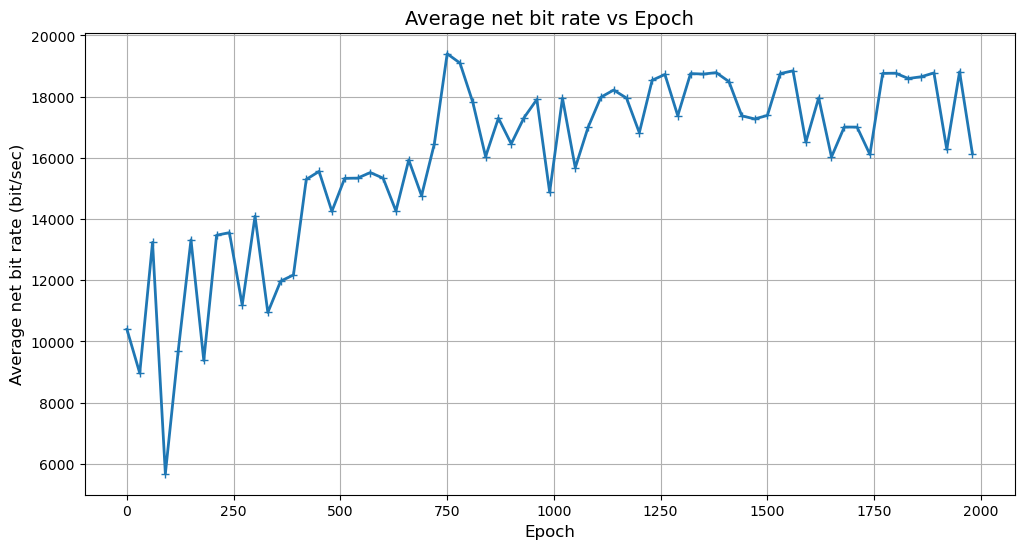

In [20]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(epochList, ave_reward, marker='+', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Average net bit rate vs Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average net bit rate (bit/sec)', fontsize=12)

# Add grid for better visualization
plt.grid(True)

# Save the plot
plt.savefig('Training P2P average_reward_vs_epochs.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [15]:
"""
Deep Deterministic Policy Gradient (DDPG), Reinforcement Learning.
P2P network, net bit rate, energy harvesting example for training.
Thanks to : https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/contents/9_Deep_Deterministic_Policy_Gradient_DDPG
Using:
tensorflow 1.0
"""
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import DDPG_CLASS
#from .DDPG_CLASS import * 

np.random.seed(1)
tf.set_random_seed(1)



#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10
modulation=0 #QPSK
snrList = []
ave_reward = []

# for modulation in range(0,3):
for snr in range(0,4,2):
#     #for modulation in range(1):
    var = 10

    tf.reset_default_graph()
    sess = tf.Session()
    with tf.name_scope('S'):
        S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
    with tf.name_scope('R'):
        R = tf.placeholder(tf.float32, [None, 1], name='r')
    with tf.name_scope('S_'):
        S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
    DDPG_CLASS.S=S
    DDPG_CLASS.R=R
    DDPG_CLASS.S_=S_
    actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
    critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
    actor.add_grad_to_graph(critic.a_grads)
    M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)


    sess.run(tf.global_variables_initializer())
    saver=tf.train.Saver(max_to_keep=100)

    if OUTPUT_GRAPH:
        tf.summary.FileWriter("logs/", sess.graph)

    print("modulation=",modulation,"snr=",snr)

    for i in range(MAX_EPISODES):

        s = env.reset_P2P(snr)

        ep_reward = 0
        for j in range(MAX_EP_STEPS):
            a = actor.choose_action(s)
            a = np.random.normal(a, var)
            a=np.clip(a,0,1)
            s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

            M.store_transition(s, a, r , s_)

            if M.pointer > MEMORY_CAPACITY:
                #tip and tip2 are only for printing`#
                if tip == 1:
                    print("memory full",j,i)
                    tip=0
                var *= 0.9995  # decay the action randomness
                if tip2 == 1 and var<0.00000001:
                    print("var zero",j,i)
                    tip2=0
                    
                b_M = M.sample(BATCH_SIZE)
                b_s = b_M[:, :state_dim]
                b_a = b_M[:, state_dim: state_dim + action_dim]
                b_r = b_M[:, -state_dim - 1: -state_dim]
                b_s_ = b_M[:, -state_dim:]

                critic.learn(b_s, b_a, b_r, b_s_)
                actor.learn(b_s)

            s = s_
            
            ep_reward += r

        if i % 30 == 0 :
            print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
            print("ave_reward",ep_reward/(j+1))

        if i == 1999:
            snrList.append(snr)
            ave_reward.append(ep_reward/(j+1))
            
        
        
#save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
#print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

modulation= 0 snr= 0
net bit rate= 200000.0 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 0
ave_reward 86993.92322291834
net bit rate= 200000.0 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 30
ave_reward 82940.25293818867
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.649872 ] epoch 60
ave_reward 66118.9263731934
net bit rate= 199999.9999999556 action [0.94506489] solar,channel,battery [-0.031192    1.2813557   0.20963566] epoch 90
ave_reward 90055.91604395866
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031192   1.2813557  0.487704 ] epoch 120
ave_reward 76751.91785294624
net bit rate= 200000.0 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 150
ave_reward 71091.0366867533
net bit rate= 200000.0 action [1.] solar,channel,battery [-0.031192   1.2813557  0.193472 ] epoch 180
ave_reward 78400.50892147522
net bit rate= 0.0 action [0.] solar,channel,battery [-0.031

ValueError: x and y must have same first dimension, but have shapes (67,) and (2,)

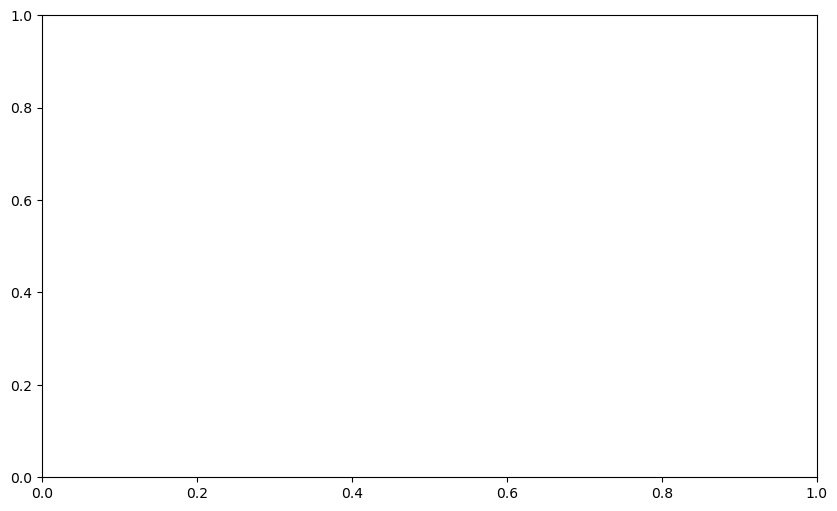

In [17]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochList, ave_reward, marker='+', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Average Reward vs SNR', fontsize=14)
plt.xlabel('SNR', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)

# Add grid for better visualization
plt.grid(True)

# Save the plot
plt.savefig('Training P2P average_reward_vs_snr.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import pickle

# Function to save variables to a file
def save_variables(filename, variables):
    with open(filename, 'P2P-Epoch-ABR') as f:
        pickle.dump(variables, f)

# Function to load variables from a file
def load_variables(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
epochList
ave_reward